## Lesson 3: Kismet Alerts
In this lesson, we'll explore the following topics:

1. A brief introduction into Kismet Alerts
2. How to query all alerts via a Kismet API running kismet on EtherEyes.
    * Query the Kismet API for all alerts
    * Convert JSON data to a pandas dataframe
    * Filter for unique alert source MAC addresses
    * Dump pcap data for each source mac alert
    
Kismetdb Documentation: https://www.kismetwireless.net/docs/readme/alerts/alerts/

## 1. Kismet Alerts
Open the Kismet WebUI on EtherEyes http://127.0.0.1:2501 and select the **Alerts** tab.  Kismet uses alerts to communicate wireless intrusion events and critical Kismet server events.  Alerts are generated both as text messages on the messagebus and as dedicated alert records.

Kismet Alerts API documentation: https://www.kismetwireless.net/docs/api/alerts/

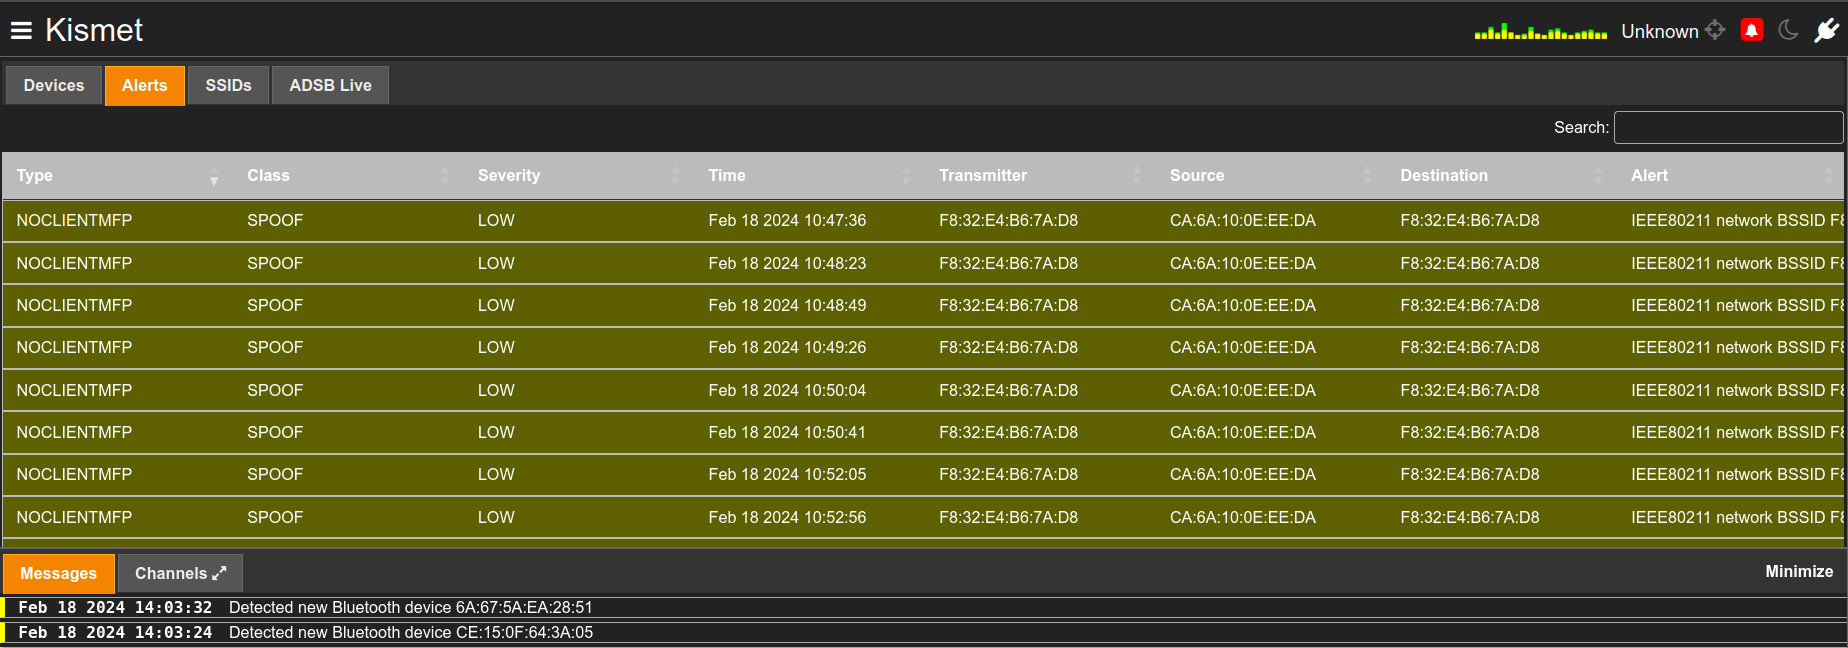

## 2. How to Query All Alerts via a Kismet API

In [72]:
from datetime import datetime
import os
import requests
import json
import pandas as pd

In [73]:
#Default EtherEyes credentials. Change as needed.
username = "ethereyes"
password = "ethereyes"

### Query the Kismet API for all alerts

In [74]:
url = "http://localhost:2501/alerts/all_alerts.json"

response = requests.get(url, auth=(username, password))

if response.status_code == 200:
    # Successful response
    data = response.content
else:
    # Handle error
    print("Request failed with status code:", response.status_code)

In [75]:
#Convert binary data to formatted json
json_data=json.loads(data)

### Convert JSON data to a pandas DataFrame

In [76]:
# Load the JSON data to a pandas DataFrame and filter specific columns
df = pd.json_normalize(json_data)
headers_to_filter = ['kismet.alert.timestamp', 'kismet.alert.source_mac','kismet.alert.header','kismet.alert.text']
df_filtered = df[headers_to_filter]
df_filtered.head()

,kismet.alert.timestamp,kismet.alert.source_mac,kismet.alert.header,kismet.alert.text
0,1.708271e+09,CA:6A:10:0E:EE:DA,NOCLIENTMFP,IEEE80211 network BSSID F8:32:E4:B6:7A:D8 clie...
1,1.708272e+09,CA:6A:10:0E:EE:DA,NOCLIENTMFP,IEEE80211 network BSSID F8:32:E4:B6:7A:D8 clie...
2,1.708272e+09,CA:6A:10:0E:EE:DA,NOCLIENTMFP,IEEE80211 network BSSID F8:32:E4:B6:7A:D8 clie...
3,1.708272e+09,CA:6A:10:0E:EE:DA,NOCLIENTMFP,IEEE80211 network BSSID F8:32:E4:B6:7A:D8 clie...
4,1.708272e+09,CA:6A:10:0E:EE:DA,NOCLIENTMFP,IEEE80211 network BSSID F8:32:E4:B6:7A:D8 clie...


### Filter for unique alert source MAC addresses

In [77]:
unique_source_macs = df['kismet.alert.source_mac'].unique()
# Print the unique values
print(unique_source_macs)

['CA:6A:10:0E:EE:DA' '22:0E:4C:A7:A1:7B']


### Dump pcap data for each source mac alert

In [78]:
def get_date_string():
    #Returns a date string in the format YYYYMMDD_HHmmSS.
    now = datetime.now()
    year = now.strftime("%Y")
    month = now.strftime("%m")
    day = now.strftime("%d")
    hour = now.strftime("%H")
    minute = now.strftime("%M")
    second = now.strftime("%S")

    date_string = f"{year}{month}{day}_{hour}{minute}{second}"
    return date_string

In [70]:
hostname = os.uname()[1]
date_string = get_date_string()
for mac_addr in unique_source_macs:
    mac_string = mac_addr.replace(':','-')
    pcap_file = "/data/"+hostname+"/pcaps/"+date_string+"_ALERT_"+mac_string+".pcap"
    url = "http://localhost:2501/logging/kismetdb/pcap/test.pcapng?address_source="+mac_addr
    response = requests.get(url, auth=(username, password))
    if response.status_code == 200:
        # Successful response
        binary_data = response.content
        with open(pcap_file, 'wb') as f:
            f.write(response.content)
    else:
        # Handle error
        print("Request failed with status code:", response.status_code)


In [71]:
!ls -l /data/ethereyes-03/pcaps/

total 4468
-rw-r--r-- 1 ethereyes kismet        865 Feb 18 19:43 1.json
-rw-r--r-- 1 ethereyes ethereyes    7812 Feb 18 13:17 20240218_131720_A6-D7-3C-08-03-D3.pcap
-rw-r--r-- 1 ethereyes kismet      30739 Feb 18 19:18 20240218_191830_alerts.pcap
-rw-r--r-- 1 ethereyes kismet      30739 Feb 18 19:19 20240218_191915_alerts.pcap
-rw-r--r-- 1 ethereyes kismet      30739 Feb 18 19:21 20240218_192139_alerts.json
-rw-r--r-- 1 ethereyes kismet      30739 Feb 18 19:22 20240218_192228_alerts.json
-rw-r--r-- 1 ethereyes kismet       5992 Feb 18 22:05 20240218_220534_00-00-00-00-00-00.pcap
-rw-r--r-- 1 ethereyes kismet     989160 Feb 18 22:05 20240218_220534_22-0E-4C-A7-A1-7B.pcap
-rw-r--r-- 1 ethereyes kismet    1423172 Feb 18 22:05 20240218_220534_CA-6A-10-0E-EE-DA.pcap
-rw-r--r-- 1 ethereyes kismet       6688 Feb 18 22:06 20240218_220635_ALERT_00-00-00-00-00-00.pcap
-rw-r--r-- 1 ethereyes kismet    1042768 Feb 18 22:06 20240218_220635_ALERT_22-0E-4C-A7-A1-7B.pcap
-rw-r--r-- 1 ethereyes kismet 